99


<Axes: title={'center': 'Portfolio Performance'}, xlabel='timestamp'>

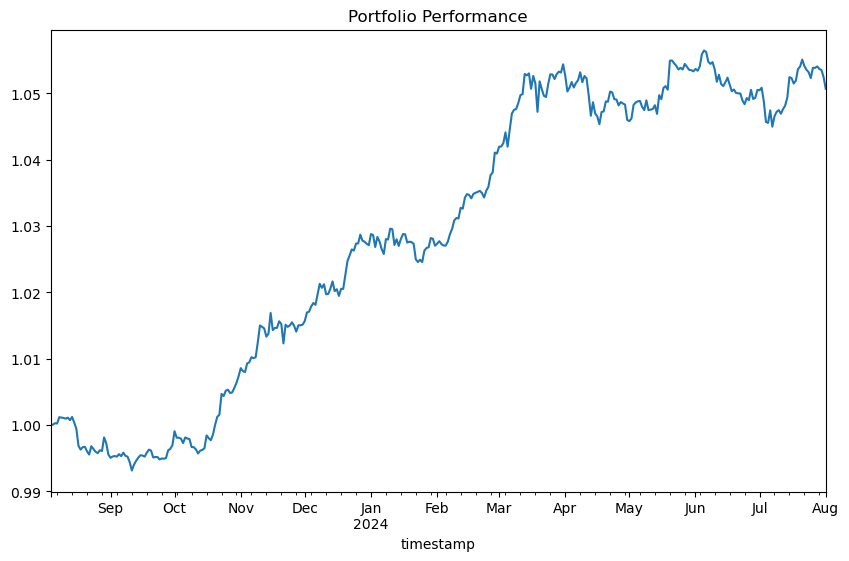

In [15]:
import pandas as pd
import ccxt
import datetime


# Getting the dataset from csv file
data = pd.read_csv('../data/crypto_top100_20240720.csv')
# Get the list from first column and convert it to list with capital letters

tickers = data['Symbol'].str.upper().tolist()


# Add the USDT to the tickers
tickers = [x + '/USDT' for x in tickers]

# Count the number of tickers
print(len(tickers))

# Initialize the exchange
exchange = ccxt.binance()

# Function to fetch historical data
def fetch_historical_data(ticker, since):
    ohlcv = exchange.fetch_ohlcv(ticker, timeframe='1d', since=since)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    return data

# Define the start date for the last 12 months
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime('%Y-%m-%d')
since = int(datetime.datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)

# Fetch historical data for all tickers and store in a dictionary
historical_data = {}
for ticker in tickers:
    try:
        historical_data[ticker] = fetch_historical_data(ticker, since)
    except Exception as e:
        break

# Combine the closing prices of all tickers into a single DataFrame
close_prices = pd.DataFrame({ticker: data['close'] for ticker, data in historical_data.items()})

# Calculate daily returns
returns = close_prices.pct_change().dropna()

# Assuming each ticker has equal weight (1)
weights = pd.Series([1] * len(tickers), index=tickers)

# Calculate the portfolio daily returns
portfolio_returns = (returns * weights).sum(axis=1) / len(tickers)

# Calculate the cumulative performance of the portfolio
portfolio_performance = (1 + portfolio_returns).cumprod()

# Draw the cumulative performance of the portfolio
portfolio_performance.plot(title='Portfolio Performance', figsize=(10, 6), legend=False)

In [29]:
# Export the portfolio performance to a CSV file
portfolio_performance.to_csv('../data/portfolio_performance.csv')

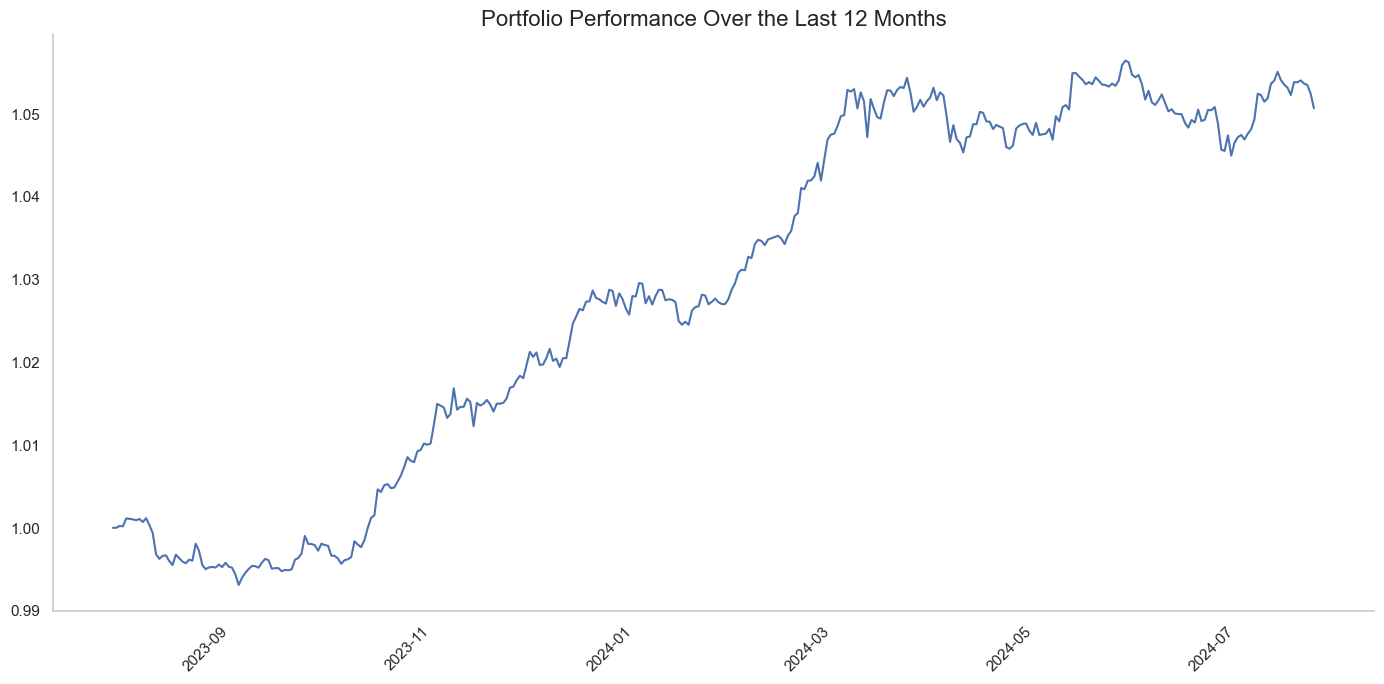

In [32]:
# First row of the portfolio performance
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting using Seaborn
portfolio_performance_df = portfolio_performance.reset_index()
portfolio_performance_df.columns = ['timestamp', 'portfolio_performance']

# Plotting using Seaborn

plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='portfolio_performance', data=portfolio_performance_df)
plt.title('Portfolio Performance Over the Last 12 Months', fontsize=16)

# Remove labels from axes
plt.xlabel('')
plt.ylabel('')

# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Cumulative Returns', fontsize=14)

# Remove the grid
plt.grid(False)

# Remove box
sns.despine()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()